# Preprocessing pipeline from scratch on auto-edw data pull

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Read in auto-edw compiled data

In [2]:
DATA_DIR = '../../../CarpeDiem Extubation Prediction Sam Alec/data'

In [6]:
edw = pd.read_excel(f'{DATA_DIR}/{script_labs_file}')

In [4]:
edw['patient_day'] = [str(r.pt_study_id)+'/'+str(r.ICU_rank)+'/'+str(r.ICU_day) for i,r in edw.iterrows()]
edw['Patient_id_2'] = [str(r.pt_study_id)+'/'+str(r.ICU_rank) for i,r in edw.iterrows()]

In [5]:
edw.pt_study_id.nunique()

712

In [6]:
edw.visit_key.nunique()

712

In [7]:
edw.ir_id.nunique()

696

In [8]:
edw.Patient_id_2.nunique()

940

## Read in old CarpeDiem dataset for formatting, data ranges

In [9]:
cd = pd.read_csv(f'{DATA_DIR}/{cd_file}')

## Clean up column names

In [10]:
# Marjorie's list to fix column names, will want to reverse this

rename_list = {#'script_id':'pt_study_id',
               'stay':'ICU_rank',
                'day':'ICU_day',
               'SOFA_score':'SOFA',
               'Intubation_flag':'intub_flag',
               'Hemodialysis_flag':'hd_flag',
               'Temperature':'Temperature_avg',
               'Heart_rate':'Heart_rate_avg',
               'Systolic_blood_pressure':'Systolic_blood_pressure_avg',
               'Diastolic_blood_pressure':'Diastolic_blood_pressure_avg',
               'Mean_arterial_pressure':'Mean_arterial_pressure_avg',## double check
               'Norepinephrine_rate':'norepinephrine_max',
               'Respiratory_rate':'Respiratory_rate_avg',
               'Oxygen_saturation':'Oxygen_saturation_avg',
               'GCS_eye_opening':'Eye_Opening_min',
               'GCS_motor_response':'Best_Motor_Response_min',
               'GCS_verbal_response':'Best_Verbal_Response_min',
                'Minute_Ventilation':'Minute_Ventilation_avg',
#                'RASS_score':'RASS_avg',
               'PEEP':'Peep_avg',
               'FiO2':'FiO2_avg',
               'Plateau_Pressure':'Plateau_Pressure_avg',
    
               'PaO2FIO2_ratio':'pO2_FiO2_ratio_min',
               'WBC_count':'wbc_avg',
               'Lymphocytes':'abs_lymphocytes_avg',
               'Neutrophils':'abs_neutrophils_avg',
               'Hemoglobin':'hemoglobin_avg',
               'Platelets':'PLATELET_min',
               'Bicarbonate':'BICARBONATE_avg',
               'Creatinine':'Creatinine_max',
               'Albumin':'ALBUMIN_avg',
               'Bilirubin':'BILIRUBIN_max',
               'CRP':'CRP_avg',
               'D_dimer':'d_dimer_avg',
               'Ferritin':'FERRITIN_avg',
               'LDH':'LDH_avg',
               'Lactic_acid':'Lactic_Acid_avg',
               'Procalcitonin':'PROCALCITONIN_avg'}
feature_map = {value: key for key, value in rename_list.items()}

In [11]:
edw_clean = edw.copy()

In [12]:
edw_clean.columns = [feature_map[col] if col in feature_map.keys() else col for col in edw_clean.columns]

In [13]:
for col in cd.columns:
    if col not in edw_clean.columns:
        print(col)

Unnamed: 0
Patient_id
patient
External_transfer_flag
Admission_source_name
Discharge_disposition
Binary_outcome
Death_date
Global_cause_failure
Patient_category
COVID_status
Age
Ethnicity
Gender
Race
Smoking_status
BMI
Admit_APS_score
Admit_SOFA_score
Cumulative_ICU_days
Number_of_ICU_stays
Tracheostomy_flag
Cumulative_intubation_days
icu_stay_start_datetime
icu_stay_stop_datetime
ICU_stay
ICU_day
Norepinephrine_flag
Urine_output
RASS_score
Lung_Compliance
PEEP_changes
Respiratory_rate_changes
FiO2_changes
ABG_pH
ABG_PaCO2
ABG_PaO2
has_bal
bal_barcode
bar_barcode
Cryopreserved_samples
Single_cell_library
Single_cell_chemistry
Episode_category
Episode_etiology
Episode_is_cured
Episode_is_cured_source
Episode_duration
Episode_duration_source


- Norepinephrine_flag, RASS_score, Lung_Compliance, ABG_pH, ABG_PaCO2, ABG_PaO2 are missing
- Expected to be missing changes

In [14]:
np.unique([x.rsplit('_',1)[0] for x in edw_clean.columns])

array(['ALBUMIN', 'Albumin', 'BICARBONATE', 'BILIRUBIN',
       'Best_Motor_Response', 'Best_Verbal_Response', 'Bicarbonate',
       'Bilirubin', 'CRP', 'CRRT', 'Creatinine', 'D', 'Diastolic_blood',
       'Diastolic_blood_pressure', 'ECMO', 'Eye_Opening', 'FERRITIN',
       'Ferritin', 'FiO2', 'GCS_eye', 'GCS_motor', 'GCS_verbal', 'Heart',
       'Heart_rate', 'Hemodialysis', 'Hemoglobin', 'Intubation', 'LDH',
       'Lactic', 'Lactic_Acid', 'Lymphocytes', 'Mean_arterial',
       'Mean_arterial_pressure', 'Minute', 'Minute_Ventilation',
       'Neutrophils', 'Norepinephrine', 'Oxygen', 'Oxygen_saturation',
       'PCO2_ART', 'PEEP', 'PH_ART', 'PLATELET', 'PO2_ART',
       'PROCALCITONIN', 'PaO2FIO2', 'Patient_id', 'Peep', 'Plateau',
       'Plateau_Pressure', 'Platelets', 'Procalcitonin', 'RASS',
       'Respiratory', 'Respiratory_rate', 'SOFA', 'Static_Compliance',
       'Systolic_blood', 'Systolic_blood_pressure', 'Temperature', 'WBC',
       'abs_eosinophils', 'abs_lymphocytes', '

Static_Compliance, PH_ART, PCO2_ART, PO2_ART, RASS

In [15]:
[x for x in edw_clean.columns if x.startswith('RASS')]

['RASS_max']

In [16]:
[x for x in edw_clean.columns if x.startswith('Static_Compliance')]

['Static_Compliance_max', 'Static_Compliance_min', 'Static_Compliance_avg']

- ABG_pH, ABG_PaCO2, ABG_PaO2
- PH_ART, PCO2_ART, PO2_ART

In [17]:
[x for x in edw_clean.columns if x.startswith('PH_ART')]

['PH_ART_max', 'PH_ART_min', 'PH_ART_avg']

In [18]:
[x for x in edw_clean.columns if x.startswith('PCO2_ART')]

['PCO2_ART_max', 'PCO2_ART_min', 'PCO2_ART_avg']

In [19]:
[x for x in edw_clean.columns if x.startswith('PO2_ART')]

['PO2_ART_max', 'PO2_ART_min', 'PO2_ART_avg']

How about Norepinephrine_flag?

In [20]:
cd.Norepinephrine_flag.value_counts(dropna=False)

0    7985
1    4510
Name: Norepinephrine_flag, dtype: int64

If Norepinephrine is NA, then mark as 0 else 1.

In [21]:
edw_clean['Norepinephrine_flag'] = [0 if pd.isna(x) else 1 for x in edw_clean.Norepinephrine_rate]

In [22]:
edw_clean['Norepinephrine_flag'].value_counts()

0    10144
1     6261
Name: Norepinephrine_flag, dtype: int64

We should have all our matching columns now

In [23]:
extra_feature_map = {
    'RASS_max':'RASS_score',
    'Static_Compliance_avg':'Lung_Compliance',
    'PH_ART_avg':'ABG_pH',
    'PCO2_ART_avg':'ABG_PaCO2',
    'PO2_ART_avg':'ABG_PaO2'
}

edw_clean.columns = [extra_feature_map[col] if col in extra_feature_map.keys() else col for col in edw_clean.columns]

In [24]:
remove_patterns = ["_min","_max",'_avg']
drop_cols = [col for col in edw_clean.columns if any(col.endswith(combo) for combo in remove_patterns)]
edw_clean = edw_clean.drop(columns=drop_cols)

In [25]:
for col in cd.columns:
    if col not in edw_clean.columns:
        print(col)

Unnamed: 0
Patient_id
patient
External_transfer_flag
Admission_source_name
Discharge_disposition
Binary_outcome
Death_date
Global_cause_failure
Patient_category
COVID_status
Age
Ethnicity
Gender
Race
Smoking_status
BMI
Admit_APS_score
Admit_SOFA_score
Cumulative_ICU_days
Number_of_ICU_stays
Tracheostomy_flag
Cumulative_intubation_days
icu_stay_start_datetime
icu_stay_stop_datetime
ICU_stay
ICU_day
Urine_output
PEEP_changes
Respiratory_rate_changes
FiO2_changes
has_bal
bal_barcode
bar_barcode
Cryopreserved_samples
Single_cell_library
Single_cell_chemistry
Episode_category
Episode_etiology
Episode_is_cured
Episode_is_cured_source
Episode_duration
Episode_duration_source


In [26]:
for col in edw_clean.columns:
    if col not in cd.columns:
        print(col)

pt_study_id
ir_id
visit_key
day_bucket_ends
stay
day
Minute_Ventilation
patient_day
Patient_id_2


Minute_Ventilation still unmapped. Keep as feature for now

## Run outlier adjustment

Use the old CarpeDiem dataset for guidance on outlier values for each feature

In [27]:
steep_cutoff = [
    'Systolic_blood_pressure','Diastolic_blood_pressure','Respiratory_rate','PEEP','Plateau_Pressure',
    'Lung_Compliance','ABG_PaCO2','WBC_count','Lymphocytes','Neutrophils','Hemoglobin','Platelets',
    'Creatinine','CRP'
]
shallow_cutoff = [
    'Bilirubin','D_dimer','Ferritin','LDH','Lactic_acid','Procalcitonin'
]
left_steep = [
    'Temperature','Oxygen_saturation'
]
# norepinephrine

In [28]:
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array, 
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
                  upper=s.quantile(1-limits[1], interpolation='higher'))

In [29]:
def check_norepinephrine(x):
    if pd.isna(x):
        return x
    elif x < 0 or x > 1:
        return 0
    else:
        return x

skipping pt_study_id
skipping ir_id
skipping visit_key
skipping day_bucket_starts
skipping day_bucket_ends
skipping stay
skipping day
skipping SOFA_score
skipping ECMO_flag
skipping Intubation_flag
skipping Hemodialysis_flag
skipping CRRT_flag


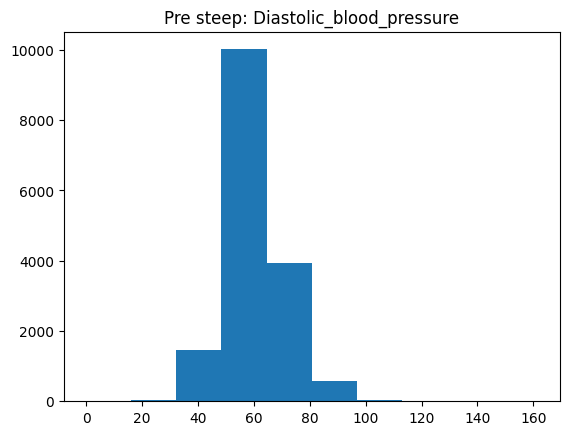

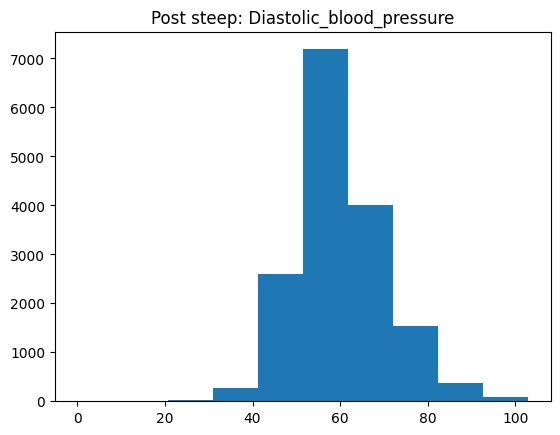

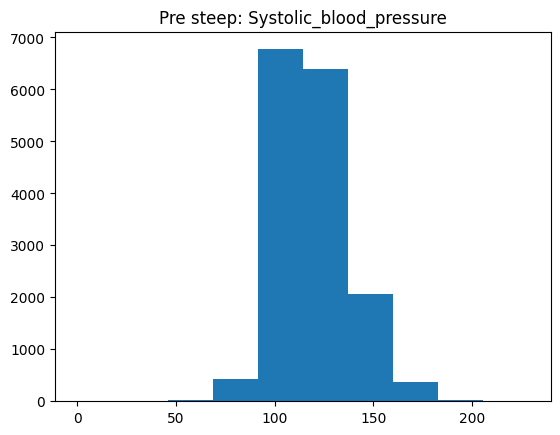

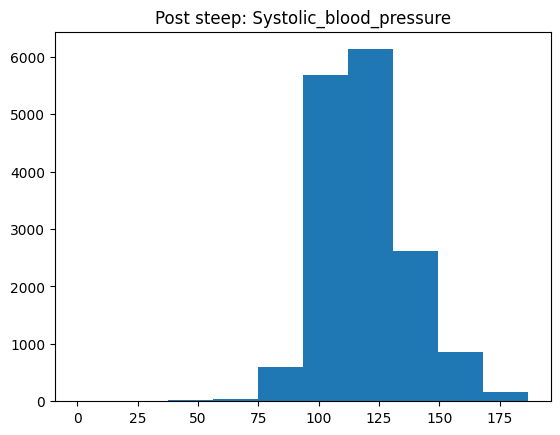

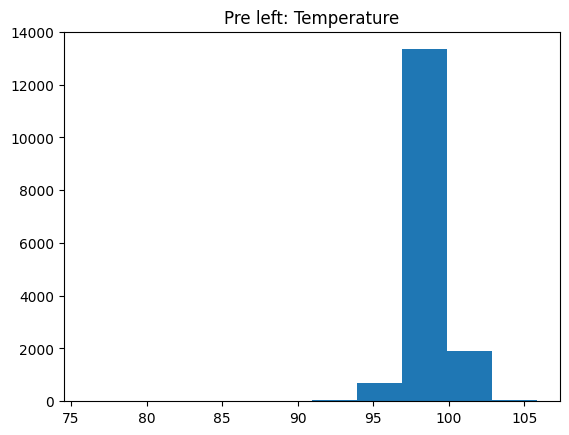

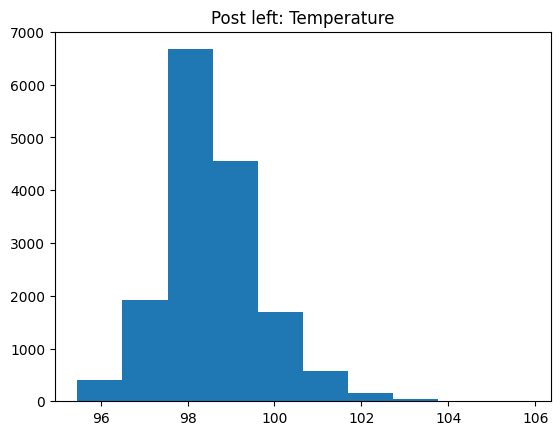

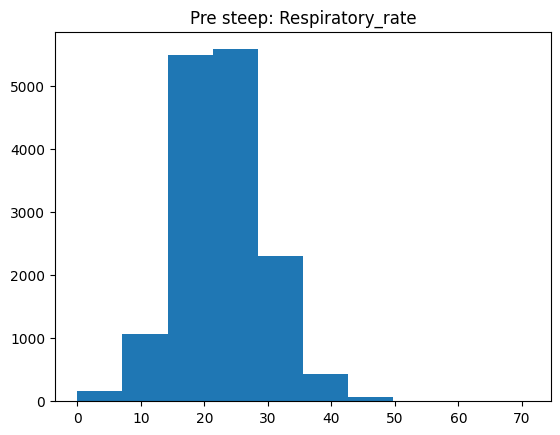

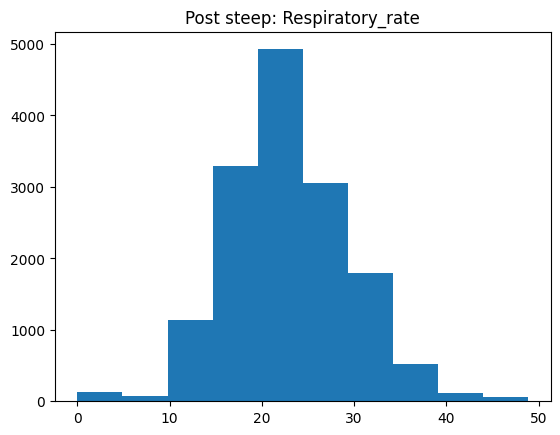

skipping Heart_rate


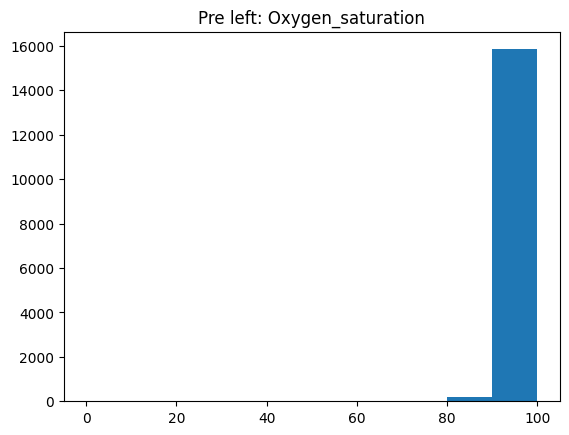

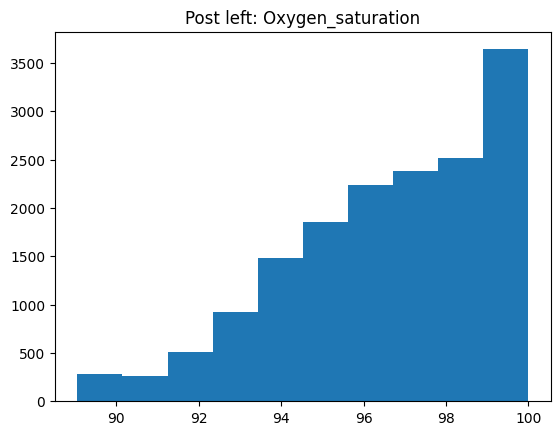

skipping RASS_score
skipping GCS_eye_opening
skipping GCS_motor_response
skipping GCS_verbal_response


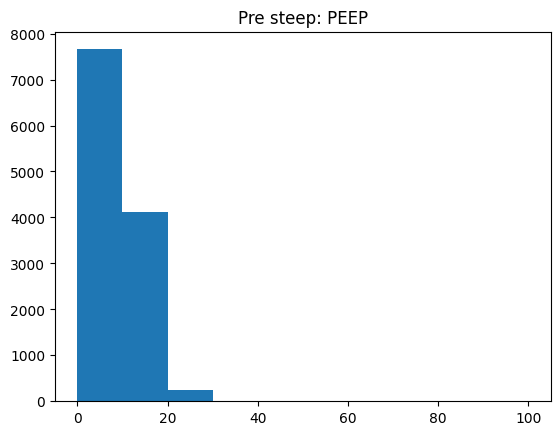

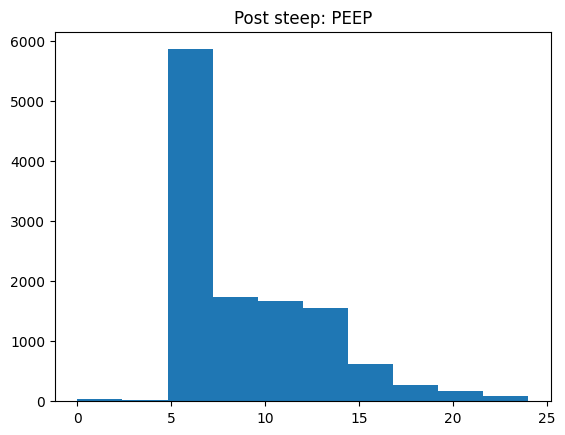

skipping FiO2


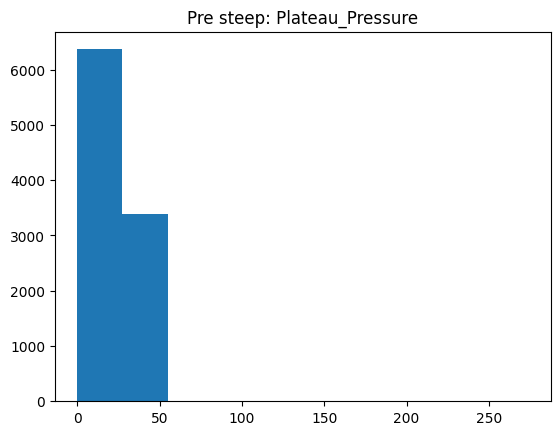

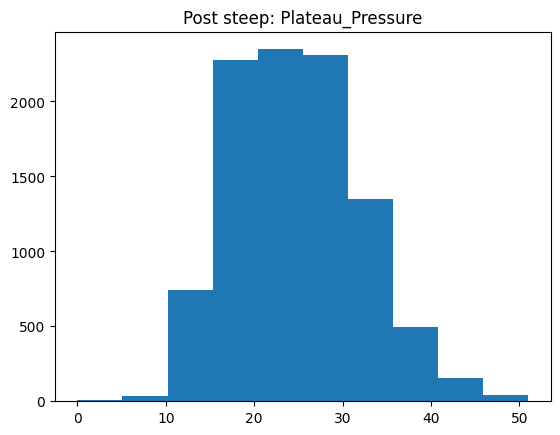

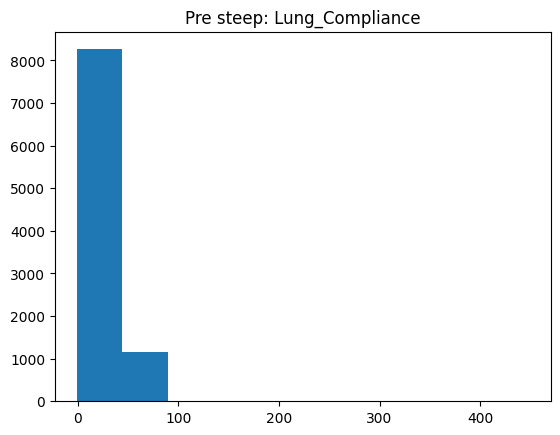

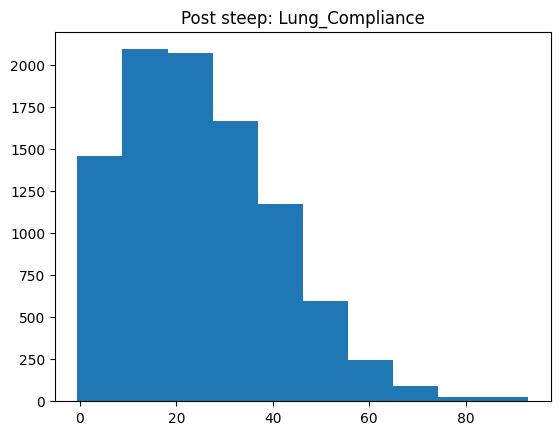

skipping Minute_Ventilation
skipping Mean_arterial_pressure


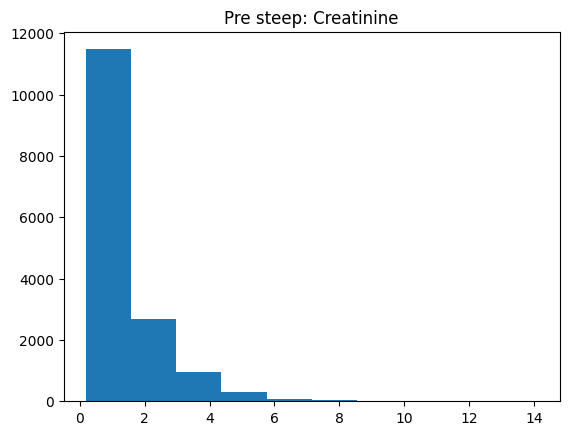

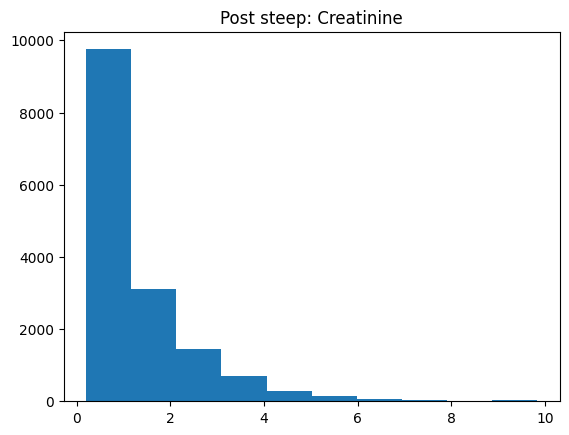

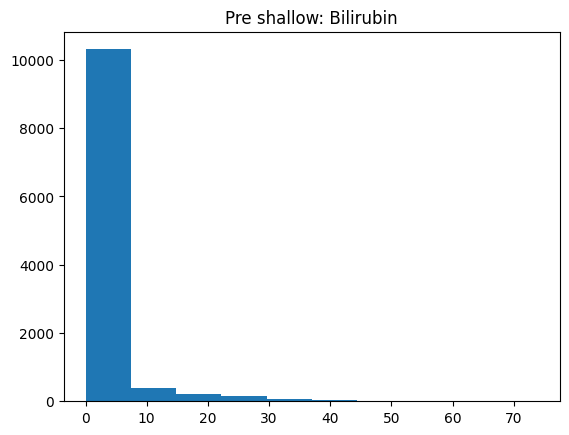

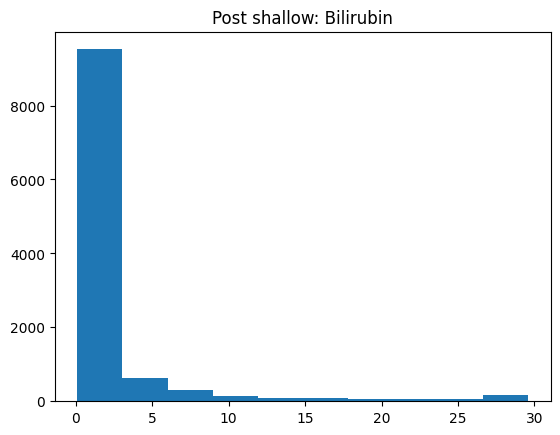

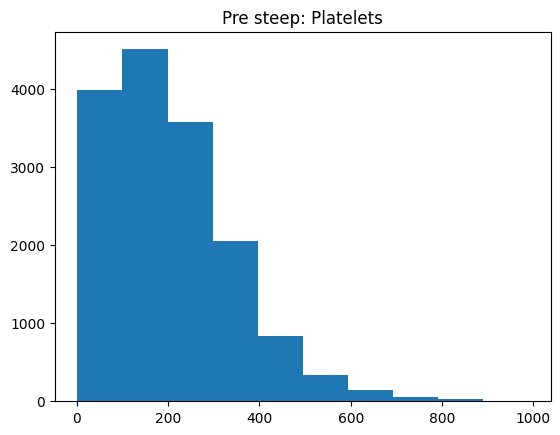

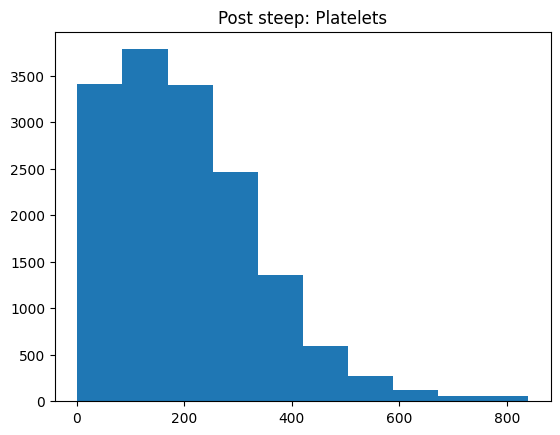

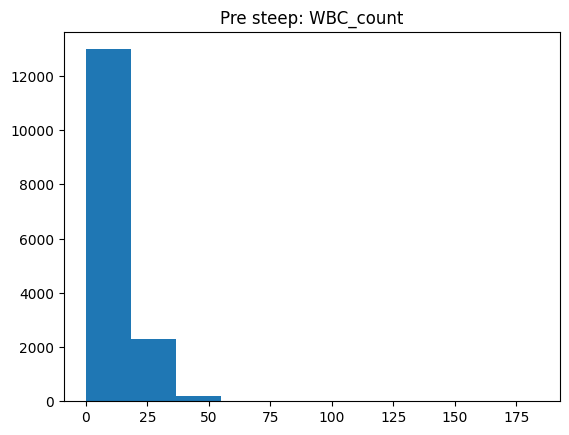

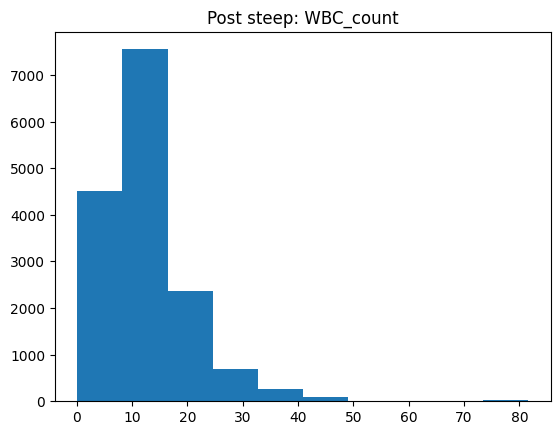

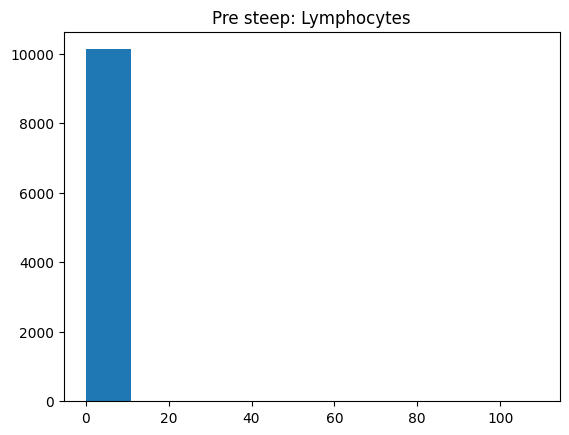

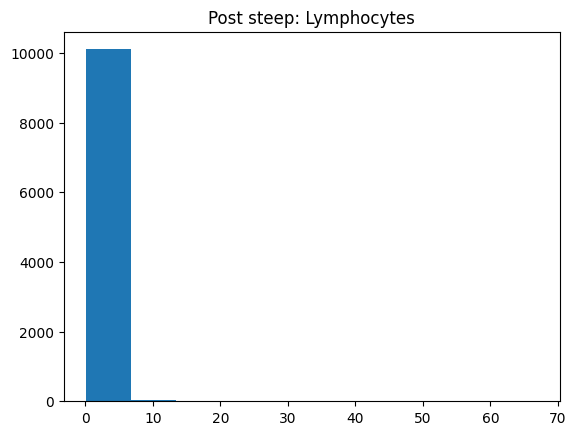

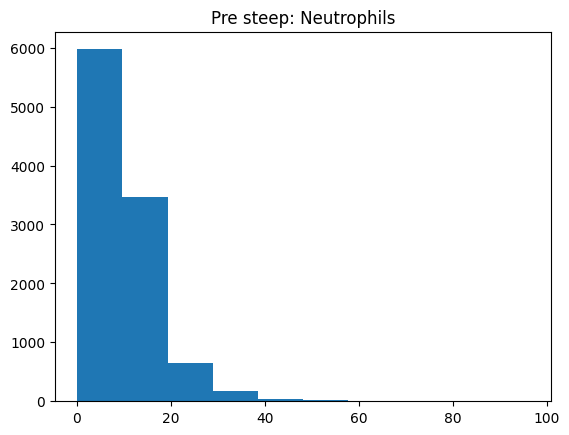

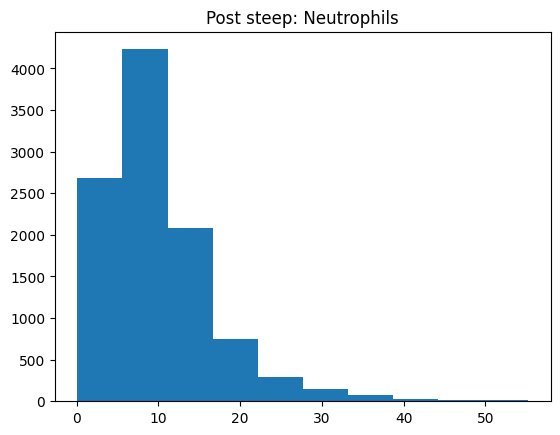

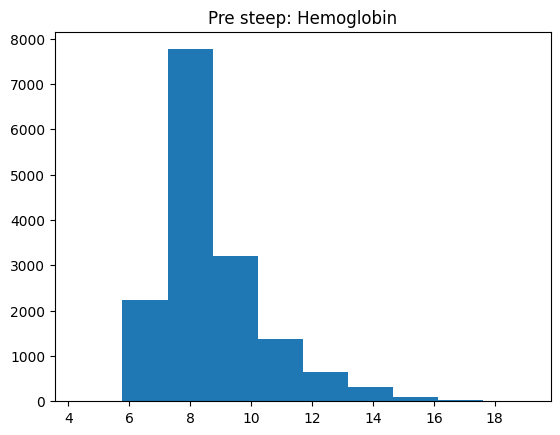

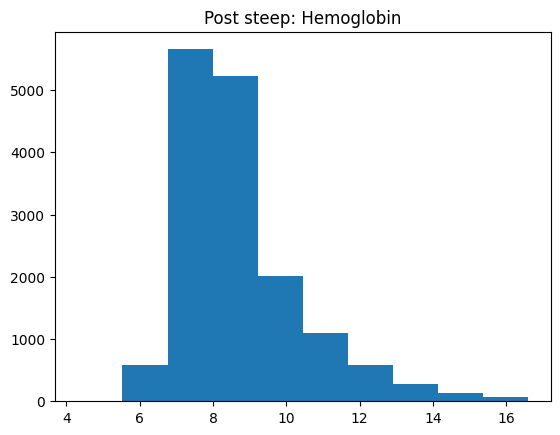

skipping Bicarbonate


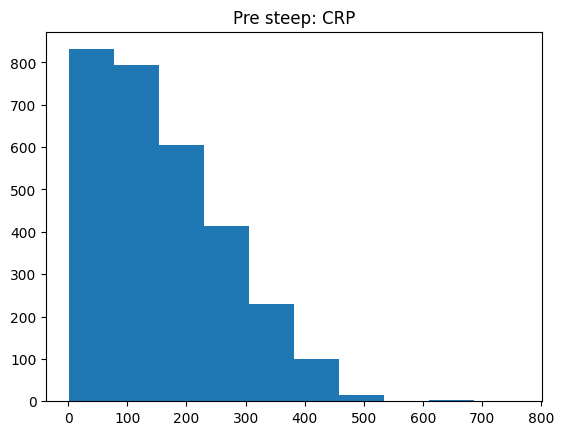

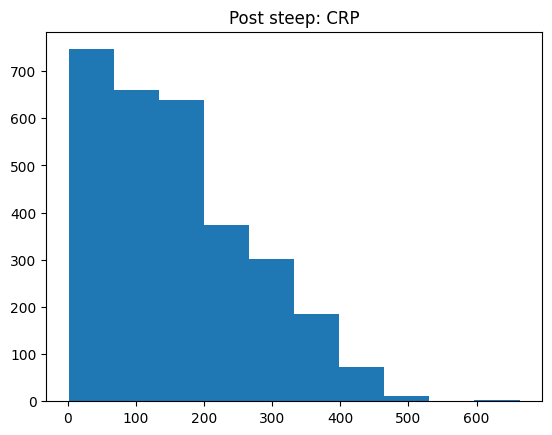

skipping Albumin


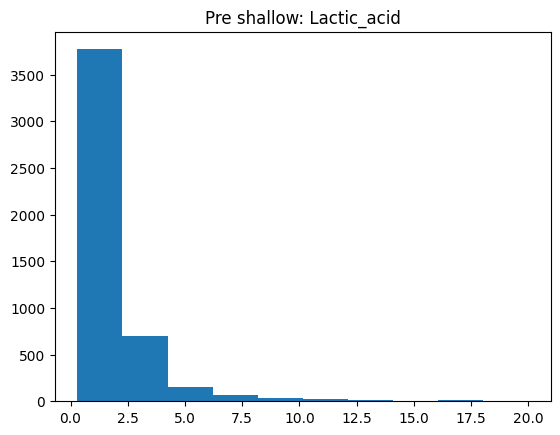

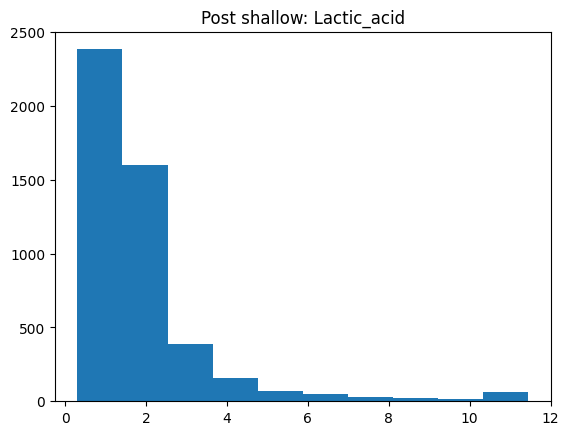

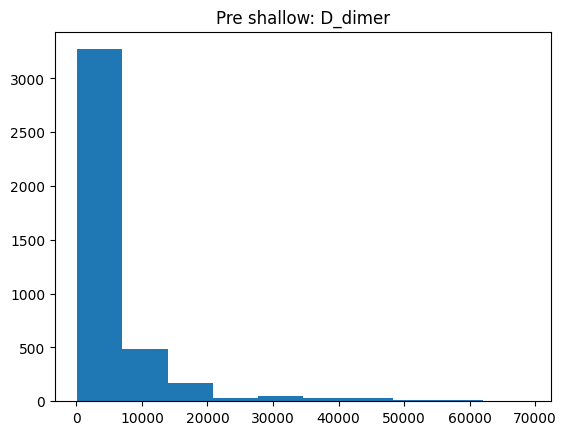

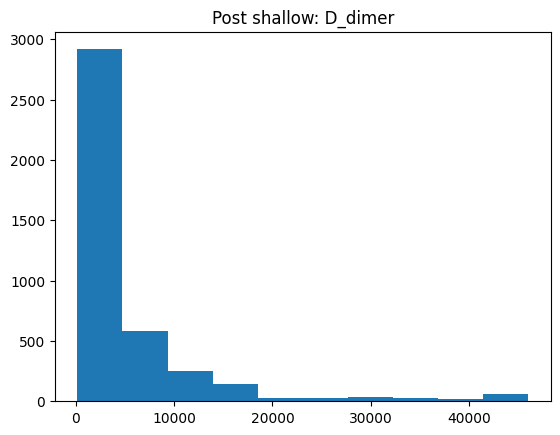

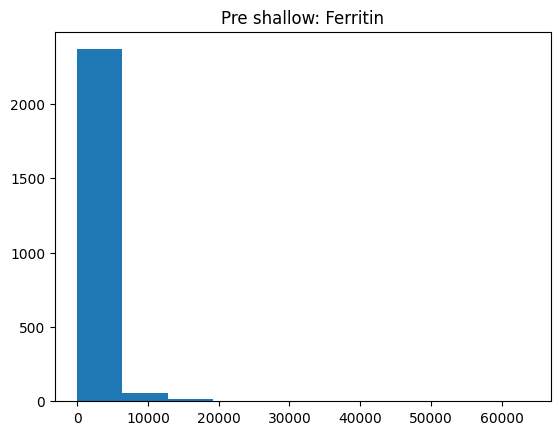

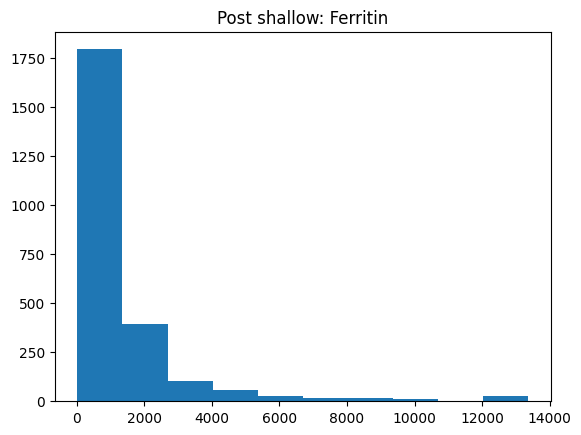

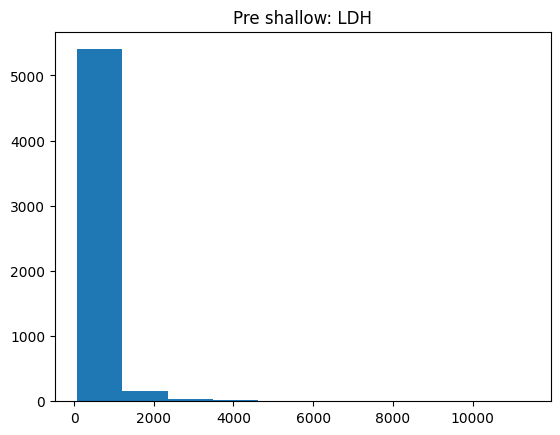

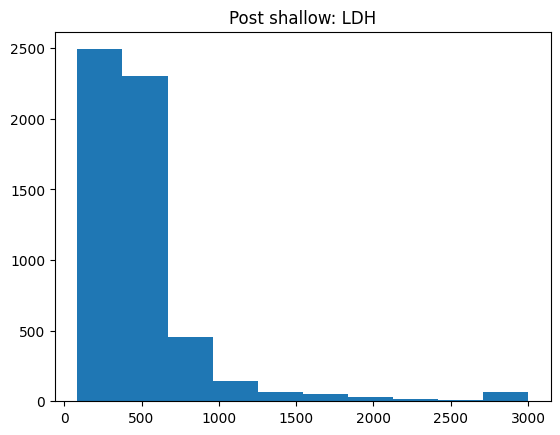

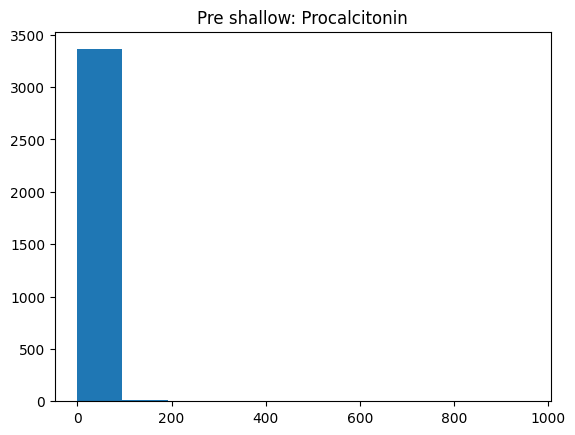

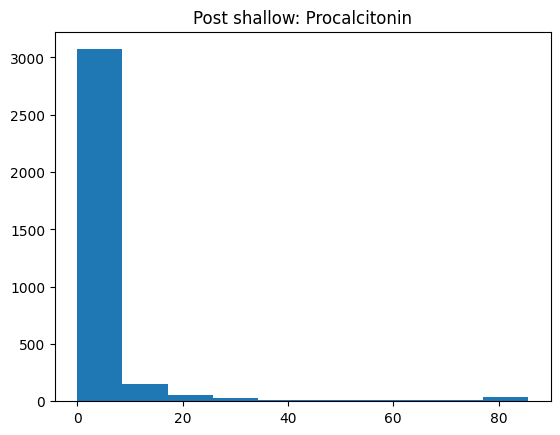

skipping ABG_PaO2


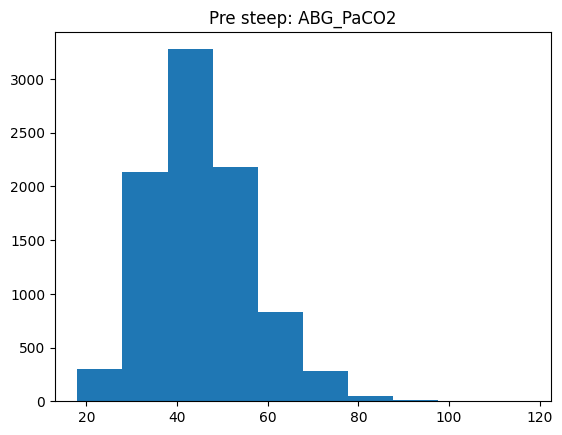

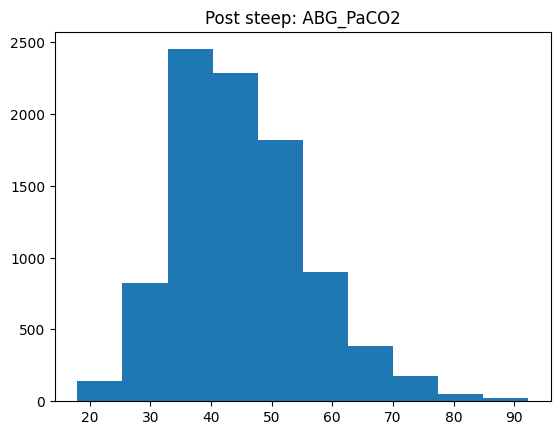

skipping ABG_pH
skipping PaO2FIO2_ratio


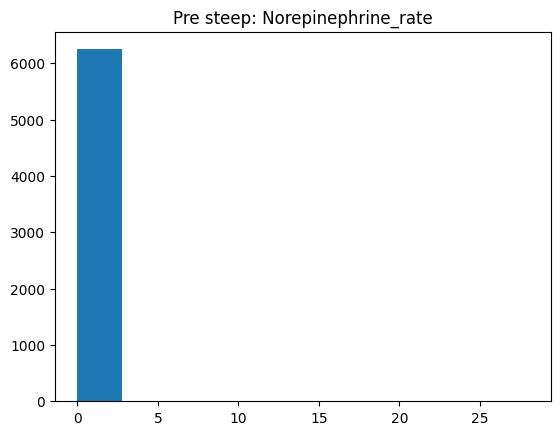

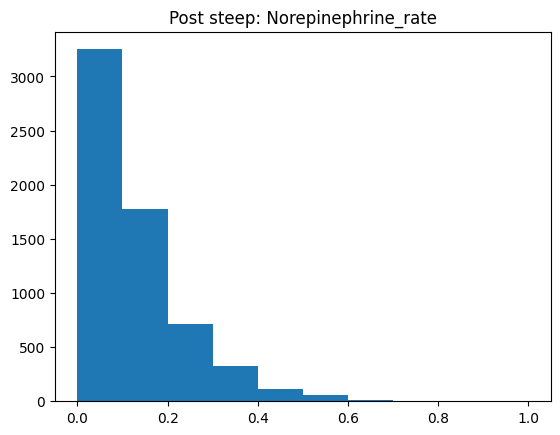

skipping patient_day
skipping Patient_id_2
skipping Norepinephrine_flag


In [30]:
skipped = []
for col in edw_clean.columns:
    if col in steep_cutoff:
        test = winsorize_with_pandas(edw_clean[col], limits=(0, 0.001))
        cut = 'steep'
    elif col in shallow_cutoff:
        test = winsorize_with_pandas(edw_clean[col], limits=(0, 0.01))
        cut = 'shallow'
    elif col in left_steep:
        test = winsorize_with_pandas(edw_clean[col], limits=(0.01, 0))
        cut = 'left'
    elif col == 'Norepinephrine_rate':
        test = [check_norepinephrine(x) for x in edw_clean[col]]
    else:
        print(f"skipping {col}")
        skipped.append(col)
        continue
    
    # print(col)
    plt.hist(edw_clean[col])
    plt.title(f'Pre {cut}: {col}')
    plt.show()
    plt.hist(test)
    plt.title(f'Post {cut}: {col}')
    plt.show()


In [31]:
ignore = ['pt_study_id',
 'ir_id',
 'visit_key',
 'day_bucket_starts',
 'day_bucket_ends',
 'stay',
 'day','patient_day','Patient_id_2']

for col in skipped:
    if col not in ignore:
        if col not in cd.columns:
            print(f"missing {col} in CarpeDiem\n")
            continue
        else:
            max_diff = (edw_clean[col].max() - cd[col].max())/cd[col].max()
            min_diff = (edw_clean[col].min() - cd[col].min())/cd[col].min()
            print(f"{col} min diff: {min_diff}")
            print(f"{col} max diff: {max_diff}\n")

SOFA_score min diff: nan
SOFA_score max diff: 0.0

ECMO_flag min diff: nan
ECMO_flag max diff: 0.0

Intubation_flag min diff: nan
Intubation_flag max diff: 0.0

Hemodialysis_flag min diff: nan
Hemodialysis_flag max diff: 0.0

CRRT_flag min diff: nan
CRRT_flag max diff: 0.0

Heart_rate min diff: -0.3153153153153153
Heart_rate max diff: 0.0573986308583444

RASS_score min diff: -0.0
RASS_score max diff: 0.3333333333333333

GCS_eye_opening min diff: 0.0
GCS_eye_opening max diff: 0.0

GCS_motor_response min diff: 0.0
GCS_motor_response max diff: 0.0

GCS_verbal_response min diff: 0.0
GCS_verbal_response max diff: 0.0

FiO2 min diff: 0.0
FiO2 max diff: 0.0

missing Minute_Ventilation in CarpeDiem

Mean_arterial_pressure min diff: -0.16649999999999993
Mean_arterial_pressure max diff: 0.4307438016528926

Bicarbonate min diff: -0.0967741935483871
Bicarbonate max diff: 0.0

Albumin min diff: 0.0
Albumin max diff: 0.6

ABG_PaO2 min diff: 0.12903225806451613
ABG_PaO2 max diff: 0.002114164904862579

Clear PaO2FIO2_ratio outliers

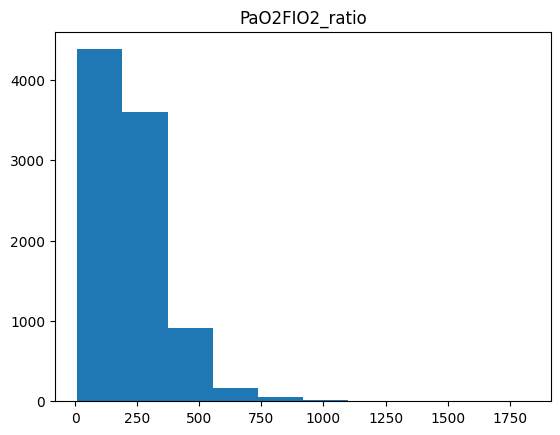

In [32]:
plt.hist(edw_clean['PaO2FIO2_ratio'])
plt.title('PaO2FIO2_ratio')
plt.show()

In [33]:
edw_clean.PaO2FIO2_ratio.max()

1825.0

Try with steep cutoff

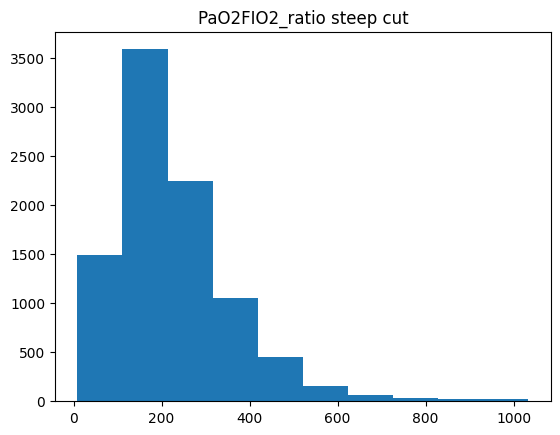

In [34]:
test = winsorize_with_pandas(edw_clean['PaO2FIO2_ratio'], limits=(0, 0.001))
plt.hist(test)
plt.title('PaO2FIO2_ratio steep cut')
plt.show()

Roll with this. Now check Minute_Ventilation

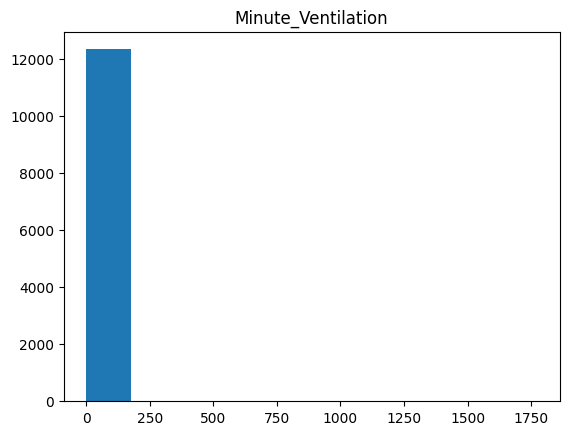

In [35]:
plt.hist(edw_clean['Minute_Ventilation'])
plt.title('Minute_Ventilation')
plt.show()

In [36]:
edw_clean.Minute_Ventilation.max()

1773.12

Outliers again, check steep/shallow cut

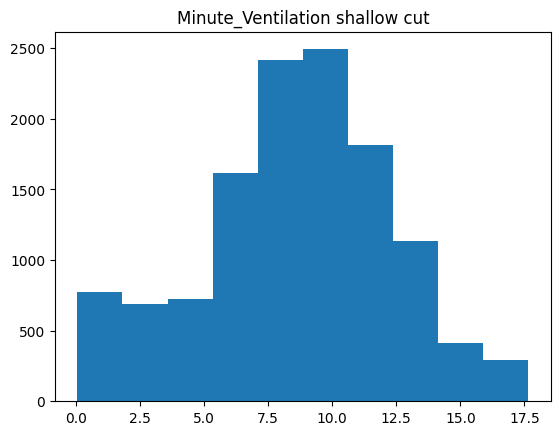

In [37]:
test = winsorize_with_pandas(edw_clean['Minute_Ventilation'], limits=(0, 0.01))
plt.hist(test)
plt.title('Minute_Ventilation shallow cut')
plt.show()

In [38]:
steep_cutoff = [
    'Systolic_blood_pressure','Diastolic_blood_pressure','Respiratory_rate','PEEP','Plateau_Pressure',
    'Lung_Compliance','ABG_PaCO2','WBC_count','Lymphocytes','Neutrophils','Hemoglobin','Platelets',
    'Creatinine','CRP','PaO2FIO2_ratio'
]
shallow_cutoff = [
    'Bilirubin','D_dimer','Ferritin','LDH','Lactic_acid','Procalcitonin','Minute_Ventilation'
]
left_steep = [
    'Temperature','Oxygen_saturation'
]
# norepinephrine

Looks good, now actully overwrite the columns

In [39]:
for col in edw_clean.columns:
    if col in steep_cutoff:
        test = winsorize_with_pandas(edw_clean[col], limits=(0, 0.001))
        cut = 'steep'
    elif col in shallow_cutoff:
        test = winsorize_with_pandas(edw_clean[col], limits=(0, 0.01))
        cut = 'shallow'
    elif col in left_steep:
        test = winsorize_with_pandas(edw_clean[col], limits=(0.01, 0))
        cut = 'left'
    elif col == 'Norepinephrine_rate':
        test = [check_norepinephrine(x) for x in edw_clean[col]]
    else:
        print(f"skipping {col}")
        continue
    edw_clean[col] = test

skipping pt_study_id
skipping ir_id
skipping visit_key
skipping day_bucket_starts
skipping day_bucket_ends
skipping stay
skipping day
skipping SOFA_score
skipping ECMO_flag
skipping Intubation_flag
skipping Hemodialysis_flag
skipping CRRT_flag
skipping Heart_rate
skipping RASS_score
skipping GCS_eye_opening
skipping GCS_motor_response
skipping GCS_verbal_response
skipping FiO2
skipping Mean_arterial_pressure
skipping Bicarbonate
skipping Albumin
skipping ABG_PaO2
skipping ABG_pH
skipping patient_day
skipping Patient_id_2
skipping Norepinephrine_flag


Save to intermediate file

In [10]:
# edw_clean.to_csv()